In [1]:
%matplotlib inline

from collections import defaultdict
import scipy
import traceback
import os
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
import sys
import seaborn as sns; sns.set()  # for plot styling

import sklearn.cluster
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#LOAD DATA
input_path = 'filtered_gene_bc_matrices/zv10_gtf89_cloche_gfp/'

if os.path.isfile(input_path + '/matrix.npz'):
    E = scipy.sparse.load_npz(input_path + '/matrix.npz')
else:
    E = scipy.io.mmread(input_path + '/matrix.mtx').T.tocsc()
    scipy.sparse.save_npz(input_path + '/matrix.npz', E, compressed=True)

print(E.shape)


(1640, 25260)


In [19]:
from Preprocess import *

Threshold min:500 max:20000
Pre-filter: 1640 barcodes
Post-filter: 1540 barcodes
Mito fraction filter: 0.04
Pre-filter: 1540 barcodes
Post-filter: 1536 barcodes


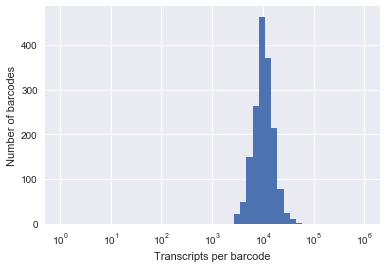

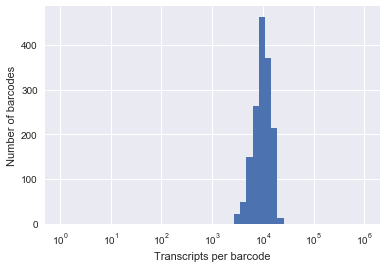

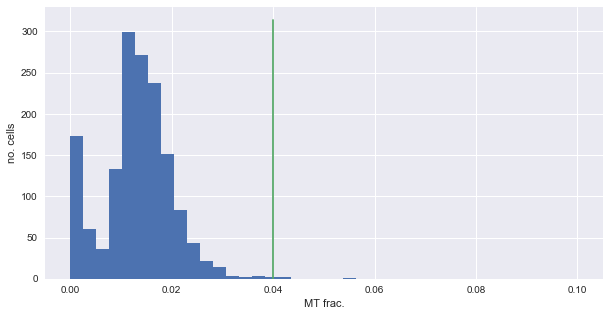

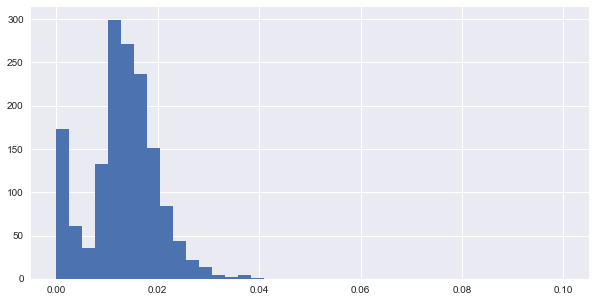

In [30]:
X = threshold(E,500,20000)[0]
X = mito_frac(X,0.04)[0]


In [31]:
X = X.toarray()
pca = PCA(n_components=20)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (1536, 25260)
transformed shape: (1536, 20)


In [75]:
from sklearn.manifold import TSNE

print(X_pca.shape)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_pca)


(1536, 20)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1536 samples in 0.003s...
[t-SNE] Computed neighbors for 1536 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1536
[t-SNE] Computed conditional probabilities for sample 1536 / 1536
[t-SNE] Mean sigma: 34.228652
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.856255
[t-SNE] Error after 300 iterations: 1.130948


In [48]:
from scipy import linalg
import itertools
from sklearn import mixture
import matplotlib as mpl

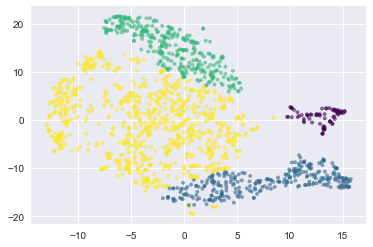

In [84]:
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full').fit(tsne_results)
colormap = gmm.predict(tsne_results)
plt.scatter(tsne_results[:,0], tsne_results[:,1],marker = '.', alpha=0.6,c=colormap, cmap='viridis')

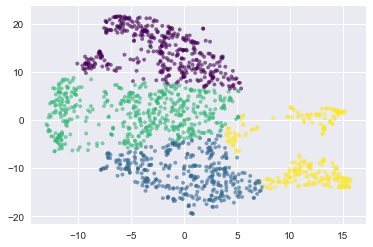

In [85]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tsne_results)
y_kmeans = kmeans.predict(tsne_results)
plt.scatter(tsne_results[:,0], tsne_results[:,1],marker = '.', alpha=0.6,c=y_kmeans, cmap='viridis')

In [83]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
#         angle = np.arctan(u[1] / u[0])
#         angle = 180. * angle / np.pi  # convert to degrees
#         ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
#         ell.set_clip_box(splot.bbox)
#         ell.set_alpha(0.5)
#         splot.add_artist(ell)


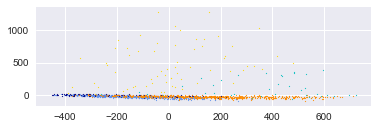

In [56]:
plot_results(X_pca, gmm.predict(X_pca), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')


